In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import pprint

import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
%load_ext watermark
%watermark -iv -p sklearn

pandas     0.24.0
seaborn    0.9.0
matplotlib 3.0.2
scipy      1.2.0
numpy      1.15.4
sklearn 0.20.2


In [3]:
def remove_borders(ax):
    sns.despine(ax=ax)
    return ax

def remove_borders2(axs):
    for ax in axs:
        remove_borders(ax)
    return axs

## Read in the data set

In [4]:
data = pd.read_pickle("../data/MERGED2016_17_select.pck")

In [5]:
data.shape

(1828, 44)

In [6]:
data.columns

Index(['HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI', 'RELAFFIL',
       'ADM_RATE', 'SAT_AVG', 'UGDS', 'UGDS_WHITE', 'UGDS_ASIAN', 'UGDS_NHPI',
       'UGDS_2MOR', 'UGDS_NRA', 'UGDS_UNKN', 'PPTUG_EF', 'TUITIONFEE_IN',
       'TUITFTE', 'INEXPFTE', 'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'PFTFTUG1_EF',
       'INSTNM', 'CITY', 'STABBR', 'ALIAS', 'INSTURL', 'ZIP', 'GRAD_DEBT_MDN',
       'BACH_ONLY', 'PUBLIC', 'PART_TIME_lower', 'PART_TIME_medium',
       'TRANSFERS_lower', 'INCLUSIVE_more_selective', 'INCLUSIVE_selective',
       'SIZECAT_medium', 'SIZECAT_small', 'SIZECAT_very_small',
       'RESIDENTIAL_nonresidential', 'RESIDENTIAL_residential'],
      dtype='object')

In [7]:
# these are just used to identify the colleges, but 
# not to predict debt
college_labels = ['INSTNM', 'CITY', 'STABBR', 'ALIAS',
                 'INSTURL', 'ZIP']
labels_data = data[college_labels]
data = data.drop(columns=college_labels)



In [8]:
predictors = [
       'ADM_RATE', 'SAT_AVG', 'UGDS', 'UGDS_WHITE', 'UGDS_ASIAN', 'UGDS_NHPI',
       'UGDS_2MOR', 'UGDS_NRA', 'UGDS_UNKN', 'PPTUG_EF', 'TUITFTE', 'TUITIONFEE_IN', 'INEXPFTE',
       'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'PFTFTUG1_EF' ] 

categorical_predictors = ['HBCU', 'PBI', 'ANNHI', 'TRIBAL', 'AANAPII', 'HSI', 'NANTI', 'RELAFFIL',
       'BACH_ONLY', 'PUBLIC',
       'PART_TIME_lower', 'PART_TIME_medium', 'TRANSFERS_lower',
       'INCLUSIVE_more_selective', 'INCLUSIVE_selective', 'SIZECAT_medium',
       'SIZECAT_small', 'SIZECAT_very_small', 'RESIDENTIAL_nonresidential',
       'RESIDENTIAL_residential']

# Data cleaning 

## Remove NULLs from the numerical features

In [9]:
data[predictors].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1828 entries, 0 to 6734
Data columns (total 17 columns):
ADM_RATE         1560 non-null float64
SAT_AVG          1277 non-null float64
UGDS             1827 non-null float64
UGDS_WHITE       1827 non-null float64
UGDS_ASIAN       1827 non-null float64
UGDS_NHPI        1827 non-null float64
UGDS_2MOR        1827 non-null float64
UGDS_NRA         1827 non-null float64
UGDS_UNKN        1827 non-null float64
PPTUG_EF         1825 non-null float64
TUITFTE          1828 non-null float64
TUITIONFEE_IN    1763 non-null float64
INEXPFTE         1828 non-null float64
AVGFACSAL        1818 non-null float64
PFTFAC           1803 non-null float64
PCTPELL          1827 non-null float64
PFTFTUG1_EF      1758 non-null float64
dtypes: float64(17)
memory usage: 257.1 KB


In [10]:
def see_labels(datavec):
    return labels_data.loc[data.loc[datavec,:].index, :]

In [11]:
# cleaning up NULLs
# looks like only one school didn't report enrollment, just drop
miss_enrol = np.isnan(data.UGDS)
data = data.loc[~miss_enrol, :]

In [12]:
# these were both non-traditional colleges: an art school and a grad school
# not needed/wanted to make a general model
miss_pptug_ef = np.isnan(data.PPTUG_EF)
see_labels(miss_pptug_ef)

,INSTNM,CITY,STABBR,ALIAS,INSTURL,ZIP
1606,School of the Museum of Fine Arts at Tufts Uni...,Boston,MA,Museum School |SMFA |SMFA at Tufts,www.smfa.edu/,02115-5596
4964,Marlboro College Graduate & Professional Studies,Marlboro,VT,"Marlboro College, Marlboro College Grad School...",www.marlboro.edu/academics/graduate,05344


In [13]:
data = data.loc[~miss_pptug_ef, :]

miss_avgfacsal = np.isnan(data.AVGFACSAL)
data = data.loc[~miss_avgfacsal, :]

miss_ptef = np.isnan(data.PFTFTUG1_EF)
data = data.loc[~miss_ptef, :]

miss_pftfac = np.isnan(data.PFTFAC)
data = data.loc[~miss_pftfac, :]

miss_tuition = np.isnan(data.TUITIONFEE_IN)
data = data.loc[~miss_tuition, :]

In [14]:
# ADM_RATE and SAT_AVG are the only ones left, 
# drop them rather than guessing on so much missing data
# These can be guessed by the INCLUSIVE categoricals anyway

In [15]:
predictors.remove('SAT_AVG')
data = data.drop(columns='SAT_AVG')
predictors.remove('ADM_RATE')
data = data.drop(columns='ADM_RATE')

In [16]:
data[predictors].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1741 entries, 0 to 6734
Data columns (total 15 columns):
UGDS             1741 non-null float64
UGDS_WHITE       1741 non-null float64
UGDS_ASIAN       1741 non-null float64
UGDS_NHPI        1741 non-null float64
UGDS_2MOR        1741 non-null float64
UGDS_NRA         1741 non-null float64
UGDS_UNKN        1741 non-null float64
PPTUG_EF         1741 non-null float64
TUITFTE          1741 non-null float64
TUITIONFEE_IN    1741 non-null float64
INEXPFTE         1741 non-null float64
AVGFACSAL        1741 non-null float64
PFTFAC           1741 non-null float64
PCTPELL          1741 non-null float64
PFTFTUG1_EF      1741 non-null float64
dtypes: float64(15)
memory usage: 217.6 KB


### Categorical columns

In [17]:
data[categorical_predictors].sum()

HBCU                            84.0
PBI                             31.0
ANNHI                           11.0
TRIBAL                           2.0
AANAPII                         62.0
HSI                            194.0
NANTI                           11.0
RELAFFIL                       637.0
BACH_ONLY                      405.0
PUBLIC                         646.0
PART_TIME_lower               1274.0
PART_TIME_medium               322.0
TRANSFERS_lower                574.0
INCLUSIVE_more_selective       409.0
INCLUSIVE_selective            609.0
SIZECAT_medium                 472.0
SIZECAT_small                  635.0
SIZECAT_very_small             351.0
RESIDENTIAL_nonresidential     531.0
RESIDENTIAL_residential        544.0
dtype: float64

In [18]:
# Let's merge native american non tribal, tribal, and pacific native
# together as indigenous-serving because there are so few
# and merge predominantly black and HBCU

In [19]:
data['BLACK'] = (data.HBCU + data.PBI).astype(int)
data['INDIG'] = (data.TRIBAL + data.AANAPII + data.NANTI + data.ANNHI).astype(int)
data = data.drop(columns=['HBCU', 'PBI', 'TRIBAL', 'AANAPII', 'NANTI', 'ANNHI', 'UGDS_NHPI'])

# somebody checked off both HBCU and Predominantly Black
data.loc[data.eval('BLACK > 1'), 'BLACK'] = 1

In [20]:
categorical_predictors.remove('HBCU')
categorical_predictors.remove('PBI')
categorical_predictors.remove('TRIBAL')
categorical_predictors.remove('AANAPII')
categorical_predictors.remove('NANTI')
categorical_predictors.remove('ANNHI')
predictors.remove('UGDS_NHPI')
categorical_predictors += ['BLACK', 'INDIG']

# make sure I've cleaned up collinear features

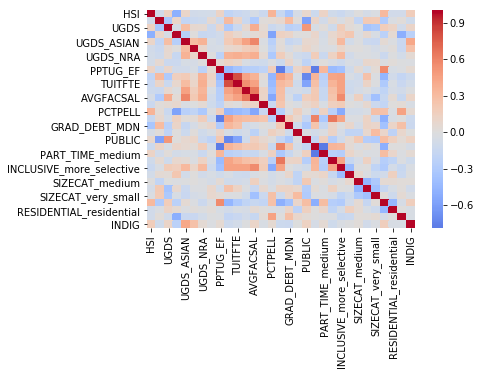

In [21]:
corr = data.corr()
sns.heatmap(data.corr(), center=0, cmap='coolwarm')

In [22]:
for i in corr.columns:
    for j in corr.columns:
        if corr.loc[i,j] > .7 and i > j: 
            print(i,j, corr.loc[i,j])

TUITIONFEE_IN TUITFTE 0.8161800403340566


In [23]:
data['COST'] = data.eval('TUITFTE + TUITIONFEE_IN')
data = data.drop(columns=['TUITFTE', 'TUITIONFEE_IN'])

In [24]:
predictors.remove('TUITFTE')
predictors.remove('TUITIONFEE_IN')
predictors.append('COST')
predictors.remove('UGDS_WHITE')
predictors.remove('UGDS_ASIAN')
predictors.remove('UGDS_2MOR')
predictors.remove('UGDS_UNKN')

## Setting up modeling

In [25]:
# scale all the numerical predictors
data[predictors].describe().T

,count,mean,std,min,25%,50%,75%,max
UGDS,1741.0,5129.614589,7331.113677,39.0000,1090.0000,2189.0000,5631.0000,55113.0000
UGDS_NRA,1741.0,0.040572,0.053102,0.0000,0.0085,0.0223,0.0513,0.5525
PPTUG_EF,1741.0,0.148977,0.162052,0.0000,0.0356,0.0973,0.2025,0.9547
INEXPFTE,1741.0,10443.411832,9151.433062,452.0000,6378.0000,8531.0000,11573.0000,147063.0000
AVGFACSAL,1741.0,7563.711660,2342.506220,960.0000,6025.0000,7254.0000,8840.0000,22146.0000
PFTFAC,1741.0,0.671306,0.255112,0.0385,0.4799,0.6762,0.9244,1.0000
PCTPELL,1741.0,0.379446,0.168205,0.0000,0.2643,0.3580,0.4633,0.9584
PFTFTUG1_EF,1741.0,0.682737,0.205320,0.0026,0.5710,0.7109,0.8368,1.0000
COST,1741.0,34614.769098,20852.737726,1766.0000,16307.0000,31819.0000,48067.0000,155049.0000


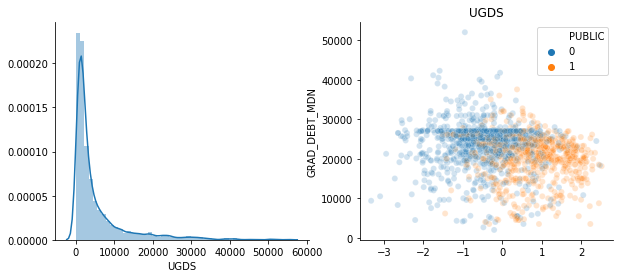

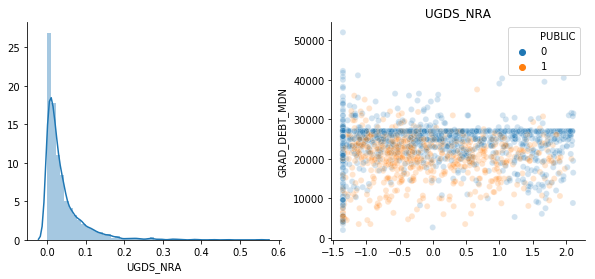

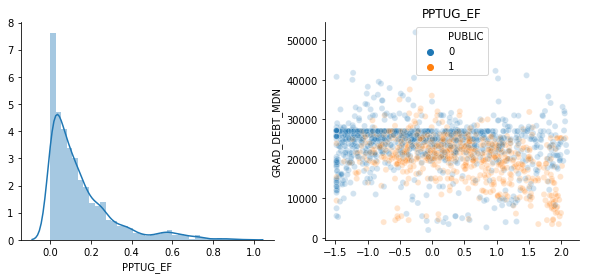

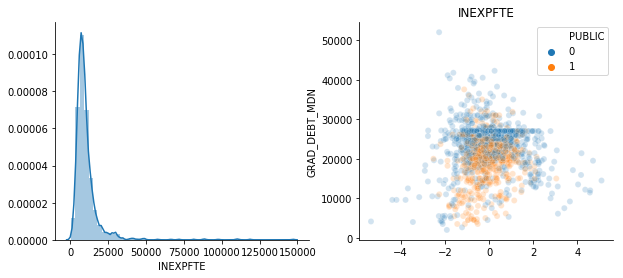

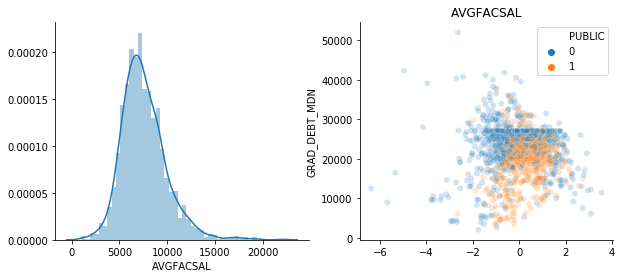

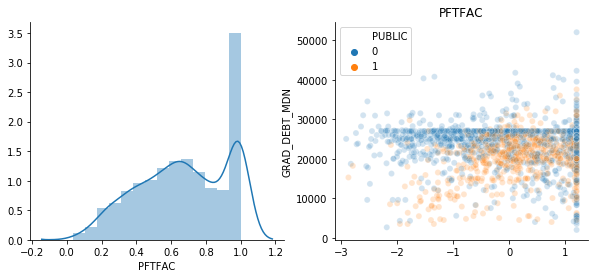

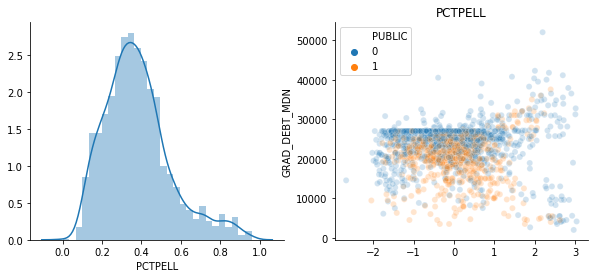

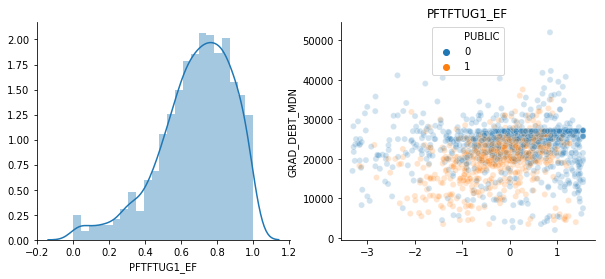

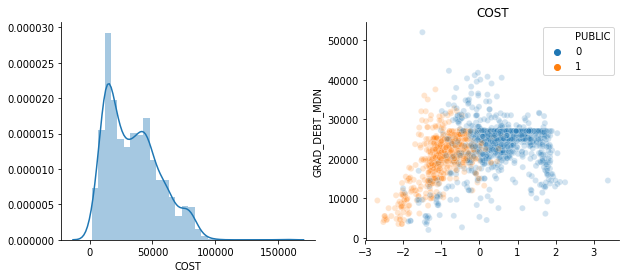

In [26]:
## make sure it all scales nice
# Tried moving columns around to minimize heteroskedacity
ss = StandardScaler()
log_std = make_pipeline(
    FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=False),
    StandardScaler()
)
scale_pwr = PowerTransformer()

log_cols = [ 'PFTFAC', 'UGDS', 'AVGFACSAL', 'INEXPFTE', 'PCTPELL' ]
pow_cols = [  'UGDS_NRA', 'PPTUG_EF', 'COST' ]
std_cols = [ 'PFTFTUG1_EF' ]

for col in predictors:
    if col in log_cols:
        x = log_std.fit_transform(data[col].values.reshape(-1,1))
    elif col in pow_cols:
        x = scale_pwr.fit_transform(data[col].values.reshape(-1,1))
    elif col in std_cols:
        x = ss.fit_transform(data[col].values.reshape(-1,1))
    else:
        print(col)
        assert(False) # we should have everybody on the list now!
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    sns.scatterplot(x=x.reshape(-1), y=data.GRAD_DEBT_MDN, hue=data.PUBLIC, ax=axs[1], alpha=0.2)
    sns.distplot(data[col], ax=axs[0])
    remove_borders2(axs)
    plt.title(col)
    plt.show()

You can see that it's very common in the dataset for students to borrow the maximum amount the federal government will loan for four years of education. (The dark horizontal line in all the above graphs in the right column.)


### Train_test_split

In [27]:
y =  data['GRAD_DEBT_MDN']
X_columns = std_cols + pow_cols + log_cols + categorical_predictors
X = data[X_columns]
X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.25, random_state=42)

In [28]:
X_train.shape

(1305, 25)

In [29]:
X_test.shape

(436, 25)

In [30]:
y_train.shape

(1305,)

In [31]:
y_test.shape

(436,)

# Modeling 

In [32]:
preprocessor = ColumnTransformer(
    transformers = [
        ('std', ss, std_cols),
        ('pwr', scale_pwr, pow_cols),
        ('log', log_std, log_cols)
    ],
    remainder='passthrough'
)

## Ridge 

In [33]:
pipe = make_pipeline(
    preprocessor,
    Ridge()
)

params = {
    'ridge__alpha':np.arange(1.3, 1.7, .05)
}

search = GridSearchCV(pipe, param_grid=params, cv=3, return_train_score=False)
result = search.fit(X_train, y_train)


In [34]:
pd.DataFrame(data=result.best_estimator_.named_steps['ridge'].coef_, index=X_columns)

,0
PFTFTUG1_EF,74.819126
UGDS_NRA,-300.827544
PPTUG_EF,-255.993151
COST,5705.317879
PFTFAC,-134.148750
UGDS,-104.759134
AVGFACSAL,244.676741
INEXPFTE,-1907.952559
PCTPELL,840.932426
HSI,-4461.213973


In [35]:
pd.DataFrame(result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034877,0.003202,0.006856,0.000184,1.3,{'ridge__alpha': 1.3},0.485165,0.500941,0.477875,0.487994,0.009626,8
1,0.031346,0.002213,0.006568,0.000299,1.35,{'ridge__alpha': 1.35},0.485132,0.500992,0.477868,0.487997,0.009655,7
2,0.031497,0.000913,0.007915,0.001225,1.4,{'ridge__alpha': 1.4000000000000001},0.485097,0.501042,0.477860,0.488000,0.009684,6
3,0.035329,0.001423,0.007228,0.000737,1.45,{'ridge__alpha': 1.4500000000000002},0.485063,0.501092,0.477851,0.488002,0.009713,5
4,0.032826,0.003159,0.006628,0.000349,1.5,{'ridge__alpha': 1.5000000000000002},0.485027,0.501140,0.477842,0.488003,0.009741,3
5,0.031964,0.000706,0.006530,0.000187,1.55,{'ridge__alpha': 1.5500000000000003},0.484991,0.501188,0.477832,0.488004,0.009770,1
6,0.031046,0.000484,0.007299,0.001103,1.6,{'ridge__alpha': 1.6000000000000003},0.484955,0.501234,0.477821,0.488003,0.009798,2
7,0.029940,0.000795,0.006470,0.000283,1.65,{'ridge__alpha': 1.6500000000000004},0.484918,0.501280,0.477809,0.488003,0.009827,4


In [36]:
result.best_params_

{'ridge__alpha': 1.5500000000000003}

In [37]:
result.best_score_

0.4880035502599604

In [38]:
yhat = search.predict(X_train)
r2 = r2_score(y_train, yhat)
r2

0.5212780036923443

In [39]:
yhat = search.predict(X_test)
r2 = r2_score(y_test, yhat)
r2

0.4583544378248523

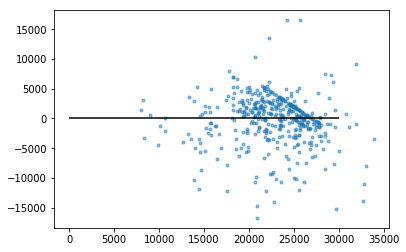

In [40]:
plt.scatter(yhat, y_test-yhat, marker='.', alpha=0.5)
plt.hlines(0,0,30000)

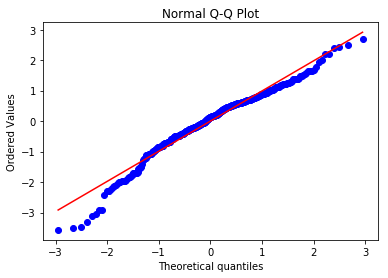

In [41]:
obs = yhat
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm", plot=plt)
fig = plt.get_current_fig_manager()
plt.title("Normal Q-Q Plot")
plt.show()

## Lasso

In [42]:
pipe = make_pipeline(
    preprocessor,
    Lasso()
)

params = {
    'lasso__alpha':np.arange(10., 30., 1.5)
}

search = GridSearchCV(pipe, param_grid=params, cv=3, return_train_score=False ) 
result = search.fit(X_train, y_train)

pd.DataFrame(data=result.best_estimator_.named_steps['lasso'].coef_, index=X_columns)

,0
PFTFTUG1_EF,2.938970
UGDS_NRA,-281.972517
PPTUG_EF,-259.966732
COST,5476.041060
PFTFAC,-104.298241
UGDS,-200.069757
AVGFACSAL,134.391632
INEXPFTE,-1796.852682
PCTPELL,787.014604
HSI,-4336.392417


In [43]:
pd.DataFrame(result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033952,0.006403,0.006158,0.000726,10,{'lasso__alpha': 10.0},0.489052,0.501208,0.479997,0.490086,0.008690,14
1,0.033372,0.001368,0.007359,0.000269,11.5,{'lasso__alpha': 11.5},0.489424,0.501496,0.480129,0.490350,0.008748,13
2,0.032199,0.001126,0.006953,0.000241,13,{'lasso__alpha': 13.0},0.489764,0.501764,0.480224,0.490584,0.008813,12
3,0.031282,0.001653,0.006364,0.000227,14.5,{'lasso__alpha': 14.5},0.490071,0.502010,0.480260,0.490780,0.008893,11
4,0.030241,0.001757,0.007051,0.000768,16,{'lasso__alpha': 16.0},0.490344,0.502233,0.480281,0.490953,0.008973,9
5,0.027707,0.000918,0.006124,0.000179,17.5,{'lasso__alpha': 17.5},0.490499,0.502410,0.480281,0.491063,0.009043,7
6,0.030742,0.002190,0.007440,0.001619,19,{'lasso__alpha': 19.0},0.490551,0.502549,0.480260,0.491120,0.009108,5
7,0.035295,0.000690,0.007064,0.000500,20.5,{'lasso__alpha': 20.5},0.490578,0.502667,0.480220,0.491155,0.009173,3
8,0.033023,0.001103,0.006861,0.000180,22,{'lasso__alpha': 22.0},0.490581,0.502766,0.480161,0.491169,0.009238,1
9,0.031711,0.001875,0.006440,0.000086,23.5,{'lasso__alpha': 23.5},0.490563,0.502845,0.480081,0.491163,0.009303,2


In [44]:
result.best_params_

{'lasso__alpha': 22.0}

In [45]:
result.best_score_

0.4911693770896302

In [46]:
yhat = search.predict(X_test)
r2 = r2_score(y_test, yhat)
r2

0.45741994254273477

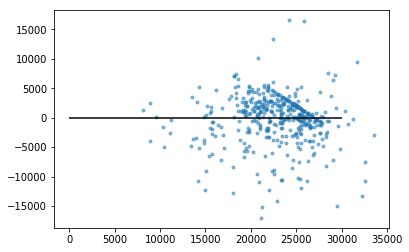

In [47]:
plt.scatter(yhat, y_test-yhat, marker='.', alpha=0.5)
plt.hlines(0,0,30000)

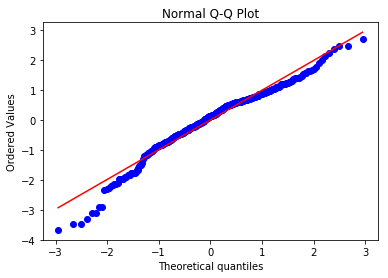

In [48]:
obs = yhat
z = (obs-np.mean(obs))/np.std(obs)
stats.probplot(z, dist="norm", plot=plt)
fig = plt.get_current_fig_manager()
plt.title("Normal Q-Q Plot")
plt.show()